In [1]:
%load_ext autoreload
%autoreload 2

In [348]:
%matplotlib inline
from cbrain.imports import *
from cbrain.utils import *
from keras.layers import *
from keras import backend as K
from keras.engine.topology import Layer

In [3]:
# Load the data
DATA_DIR = '/beegfs/DATA/pritchard/srasp/fluxbypass_aqua/'
n_days = 1
ds = xr.open_mfdataset(
    f'{DATA_DIR}AndKua_aqua_SPCAM3.0_sp_fbp_f2.cam2.h1.0000-01-0[1-{n_days}]*',
    decode_times=False)

In [16]:
print(list(ds.data_vars.keys()))

['P0', 'time_bnds', 'date_written', 'time_written', 'ntrm', 'ntrn', 'ntrk', 'ndbase', 'nsbase', 'nbdate', 'nbsec', 'mdt', 'nlon', 'wnummax', 'hyai', 'hybi', 'hyam', 'hybm', 'gw', 'ndcur', 'nscur', 'date', 'datesec', 'nsteph', 'DTV', 'FLNS', 'FLNT', 'FLUT', 'FSNS', 'FSNT', 'LHFLX', 'PHQ', 'PRECC', 'PRECL', 'PRECSC', 'PRECSL', 'PRECSTEN', 'PRECT', 'PRECTEND', 'PS', 'QAP', 'QRL', 'QRS', 'SHFLX', 'SOLIN', 'SPDQ', 'SPDT', 'T', 'TAP', 'TPHYSTND', 'TS', 'UAP', 'VAP', 'VD01']


In [428]:
# Add NORAD term to dataset
ds['TPHYSTND_NORAD'] = ds.TPHYSTND - ds.QRL - ds.QRS

## MSE conservation

### Energy conservation from raw data

- TPHYSTND = SPDT + QRL + QRS + DTV(t-1)
- DTV = SHFLX / C_P / dt

vint(TPHYSTND) + vint(PHQ) = SHFLX + LHFLX + engy(PREC) 

In [429]:
# Get statistics for a single grid point
ilat, ilon, itime = 0, 0, -1

In [433]:
a = ds.TPHYSTND_NORAD.isel(lat=ilat, lon=ilon, time=itime).values

In [477]:
def fl2hr(ds, var):
    tmp1 = G/get_dP_from_ds(ds).isel(lev=-1)
    fac = C_P if var == 'SHFLX' else L_V
    return ds[var] * tmp1 / fac

In [475]:
b = ds.SPDT.isel(lat=ilat, lon=ilon, time=itime).values
b[-1] += fl2hr(ds, 'SHFLX').isel(lat=ilat, lon=ilon, time=itime-1).values

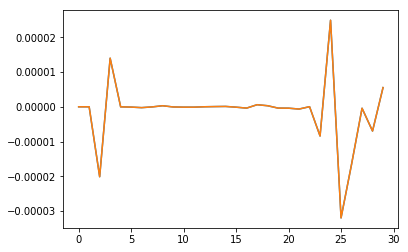

In [476]:
plt.plot(a); plt.plot(b);

In [478]:
# Precipitation term
dprec = ((ds.PRECSC + ds.PRECSL)*1e3 + ds.PRECSTEN - (ds.PRECT*1e3 + ds.PRECTEND))*L_I

In [484]:
# Surface terms
dsurf = ds.LHFLX + ds.SHFLX

In [480]:
# Convection terms
dconv = vint(ds, 'TPHYSTND_NORAD', C_P) + vint(ds, 'PHQ', L_S) #+vint(ds.PHQC)*L_I

In [481]:
# Pure SP terms
dsp = vint(ds, 'SPDT', C_P) + vint(ds, 'SPDQ', L_S)

In [486]:
tmp = [d.isel(time=itime, lat=ilat, lon=ilon).values for d in [dprec, dconv, dsp]]

In [487]:
tmp += [dsurf.isel(time=itime-1, lat=ilat, lon=ilon).values]

In [488]:
tmp

[array(-0.07156746, dtype=float32),
 array(19.21878972),
 array(0.94432083),
 array(17.180529, dtype=float32)]

In [498]:
tmp[1]-tmp[3]+tmp[0]

1.9666936212261348

In [508]:
dE = (
    dconv.isel(time=itime) - 
    dprec.isel(time=itime) - 
    dsurf.isel(time=itime-1).values
)

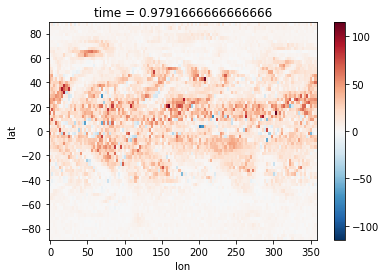

In [509]:
dE.plot();

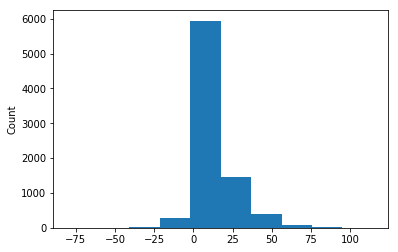

In [510]:
dE.plot.hist();

### Summary so far

- Maybe its the QC term thats missing. Include in next run. Another option would be to take a non-FBP run and test. For offline I don't think it matters.
    - Here is the plan: Need to think about which precip terms to predict
    - Which variable is my make-up variable. Probably one of the precip terms. But there I run into positivity issues. Which is probably a really good test of how well it works!
- Additionally, there is water conservation. 
- And then of course we can also combine the convective and radiative conservations. But for that I really don't have all the output I need at the moment. 
- Then I want to look at Mike's energy fixer and see whether that could be a more distributed way of adapting the outputs.

## Radiation conservation

vint(QRL)C_P + vint(QRS)C_P = FSNT - FSNS -FLNT + FLNS

### What are these F terms anyway?

In [419]:
ds.FSNT.long_name

'Net solar flux at top of model'

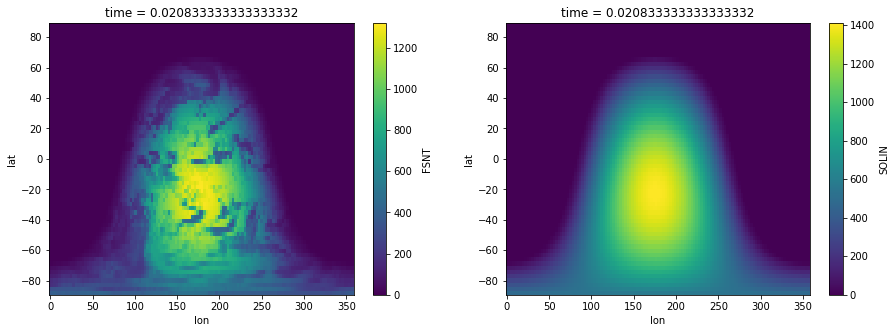

In [418]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
ds.FSNT.isel(time=1).plot(ax=axes[0])
ds.SOLIN.isel(time=1).plot(ax=axes[1]);

In [420]:
ds.FSNS.long_name

'Net solar flux at surface'

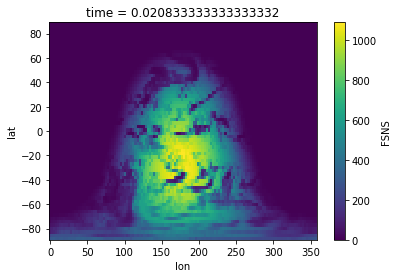

In [422]:
ds.FSNS.isel(time=1).plot();

In [424]:
ds.FLNT.long_name

'Net longwave flux at top of model'

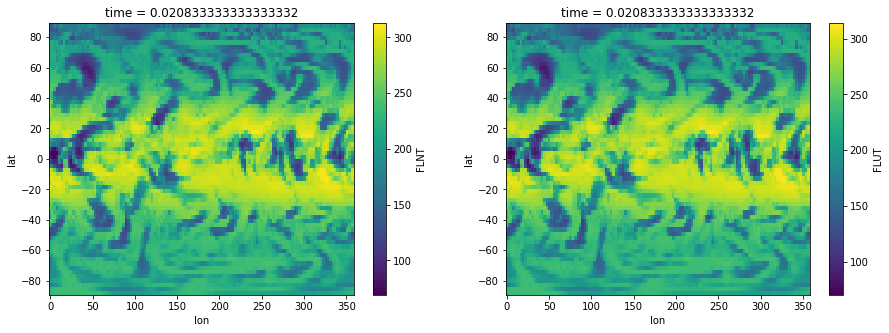

In [425]:
fig, axes = plt.subplots(1,2, figsize=(15, 5))
ds.FLNT.isel(time=1).plot(ax=axes[0])
ds.FLUT.isel(time=1).plot(ax=axes[1]);

In [426]:
ds.FLNS.long_name

'Net longwave flux at surface'

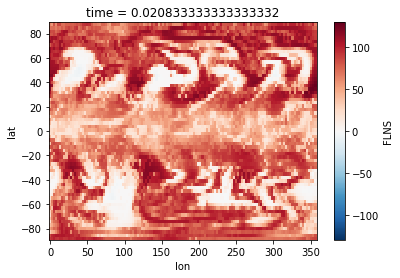

In [427]:
ds.FLNS.isel(time=1).plot();

### Test from raw data

In [294]:
flx_net = ds.FSNT - ds.FSNS - ds.FLNT + ds.FLNS

In [295]:
drad = vint(ds, 'QRL', C_P) + vint(ds, 'QRS', C_P)

In [296]:
ilat, ilon, itime = 32, 0, -1

In [297]:
flx_net.isel(time=itime, lat=ilat, lon=ilon).values

array(-97.08189, dtype=float32)

In [298]:
drad.isel(time=itime, lat=ilat, lon=ilon).values

array(-96.59567565)

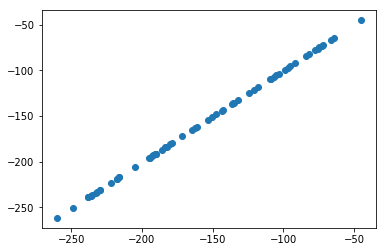

In [300]:
plt.scatter(drad.isel(lon=0, time=itime), flx_net.isel(lon=0, time=itime));

### Prepare data

- Inputs: [PS, SOLIN, TAP(z), QAP(z)]
- Outputs: [FSNT, -FSNS, -FLNT, FLNS, QRL(z), QRS(z)]

In [301]:
def get_features(ds):
    features = np.concatenate(
        [np.expand_dims(ds.PS, 1), np.expand_dims(ds.SOLIN, 1), ds.TAP, ds.QAP], 1)
    return np.rollaxis(features, 1, 4).reshape(-1, 62)

In [302]:
def get_targets(ds):
    targets = np.concatenate(
        [np.expand_dims(ds.FSNT, 1), -np.expand_dims(ds.FSNS, 1), 
         -np.expand_dims(ds.FLNT, 1), np.expand_dims(ds.FLNS, 1),
         ds.QRL*C_P, ds.QRS*C_P], 1)
    targets = np.rollaxis(targets, 1, 4).reshape(-1, 64)
    targets[:, :4] /= 1e4
    return targets

In [313]:
features = get_features(ds)
targets = get_targets(ds)
features.shape, targets.shape

((393216, 62), (393216, 64))

In [314]:
# Normalize features
fmeans = features.mean(0)
fstds = features.std(0)

In [316]:
norm = lambda x: (x - fmeans) / fstds
denorm = lambda x: x * fstds + fmeans

In [317]:
features = norm(features)

In [321]:
# Split into train and validation set
ngeo = 46*128
x_trn, x_val = features[:40*ngeo], features[40*ngeo:]
y_trn, y_val = targets[:40*ngeo], targets[40*ngeo:]
x_trn.shape, x_val.shape

((235520, 62), (157696, 62))

### Reference network

In [377]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
outp = Dense(64)(x)
net = keras.models.Model(inp, outp)

In [378]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 62)                0         
_________________________________________________________________
dense_73 (Dense)             (None, 256)               16128     
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_74 (Dense)             (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 64)                16448     
Total params: 98,368
Trainable params: 98,368
Non-trainable params: 0
_________________________________________________________________


In [379]:
net.compile('adam', 'mse')

In [380]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/10
235520/235520 [==============================] - 3s 15us/step - loss: 0.0043 - val_loss: 5.8851e-04
Epoch 2/10
235520/235520 [==============================] - 3s 13us/step - loss: 4.6238e-04 - val_loss: 3.4838e-04
Epoch 3/10
235520/235520 [==============================] - 3s 13us/step - loss: 3.2727e-04 - val_loss: 2.7062e-04
Epoch 4/10
235520/235520 [==============================] - 3s 13us/step - loss: 2.7358e-04 - val_loss: 2.3241e-04
Epoch 5/10
235520/235520 [==============================] - 3s 13us/step - loss: 2.4376e-04 - val_loss: 2.1010e-04
Epoch 6/10
235520/235520 [==============================] - 3s 13us/step - loss: 2.2446e-04 - val_loss: 1.9350e-04
Epoch 7/10
235520/235520 [==============================] - 3s 13us/step - loss: 2.1066e-04 - val_loss: 1.8229e-04
Epoch 8/10
235520/235520 [==============================] - 3s 13us/step - loss: 2.0022e-04 - val_loss: 1.7376e-04
Epoch 9/10
235520/235520 [======

In [381]:
net.optimizer.lr = 1e-4

In [382]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.7952e-04 - val_loss: 1.5621e-04
Epoch 2/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.7521e-04 - val_loss: 1.5279e-04
Epoch 3/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.7132e-04 - val_loss: 1.4907e-04
Epoch 4/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.6702e-04 - val_loss: 1.4567e-04
Epoch 5/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.6394e-04 - val_loss: 1.4396e-04
Epoch 6/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.6042e-04 - val_loss: 1.3909e-04
Epoch 7/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.5719e-04 - val_loss: 1.3762e-04
Epoch 8/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.5414e-04 - val_loss: 1.3753e-04
Epoch 9/10
235520/235520 [==

In [383]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.4619e-04 - val_loss: 1.2718e-04
Epoch 2/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.4399e-04 - val_loss: 1.3281e-04
Epoch 3/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.4186e-04 - val_loss: 1.2800e-04
Epoch 4/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.3892e-04 - val_loss: 1.2787e-04
Epoch 5/10
235520/235520 [==============================] - 3s 12us/step - loss: 1.3710e-04 - val_loss: 1.2646e-04
Epoch 6/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.3450e-04 - val_loss: 1.1978e-04
Epoch 7/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.3242e-04 - val_loss: 1.1934e-04
Epoch 8/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.3128e-04 - val_loss: 1.2155e-04
Epoch 9/10
235520/235520 [==

In [384]:
net.optimizer.lr = 1e-5
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.2533e-04 - val_loss: 1.1779e-04
Epoch 2/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.2291e-04 - val_loss: 1.1075e-04
Epoch 3/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.2107e-04 - val_loss: 1.1137e-04
Epoch 4/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.1881e-04 - val_loss: 1.0871e-04
Epoch 5/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.1777e-04 - val_loss: 1.0771e-04
Epoch 6/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.1588e-04 - val_loss: 1.0684e-04
Epoch 7/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.1292e-04 - val_loss: 1.0485e-04
Epoch 8/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.1084e-04 - val_loss: 1.0576e-04
Epoch 9/10
235520/235520 [==

In [385]:
net.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.0539e-04 - val_loss: 1.0065e-04
Epoch 2/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.0328e-04 - val_loss: 9.8267e-05
Epoch 3/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.0256e-04 - val_loss: 9.6631e-05
Epoch 4/10
235520/235520 [==============================] - 3s 13us/step - loss: 1.0048e-04 - val_loss: 9.4645e-05
Epoch 5/10
235520/235520 [==============================] - 3s 13us/step - loss: 9.8620e-05 - val_loss: 9.3094e-05
Epoch 6/10
235520/235520 [==============================] - 3s 13us/step - loss: 9.7453e-05 - val_loss: 9.5076e-05
Epoch 7/10
235520/235520 [==============================] - 3s 13us/step - loss: 9.7354e-05 - val_loss: 9.3538e-05
Epoch 8/10
235520/235520 [==============================] - 3s 12us/step - loss: 9.5981e-05 - val_loss: 9.1714e-05
Epoch 9/10
235520/235520 [==

In [404]:
def check_preds(m, s='val'):
    x, y = (x_val, y_val) if s == 'val' else (x_trn, y_trn)
    preds = m.predict(x, batch_size=1024)
    fig, axes = plt.subplots(1, 3, figsize=(15, 3))
    for ax in axes.flat:
        idx = np.random.randint(0, x.shape[0])
        ax.plot(y[idx]); ax.plot(preds[idx])
    plt.show()
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    a, b = get_dE(x, preds)
    axes[0].hist(a - b, bins=100)
    mse = np.mean((preds - y)**2, 0); var = np.var(y, 0)
    r2 = 1 - (mse/var)
    axes[1].plot(r2); axes[1].scatter(range(4), r2[:4])
    axes[1].set_ylim(0,1); axes[1].set_xlim(0, r2.size)

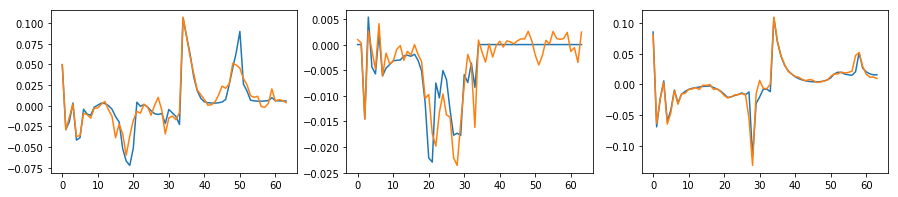

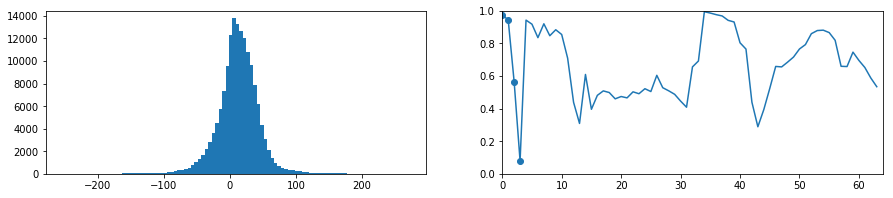

In [405]:
check_preds(net)

### Now with energy conservation

#### First the dry run

In [339]:
hyai, hybi, P0 = ds.hyai.values, ds.hybi.values, ds.P0.values

In [340]:
def get_dE(x, y):
    PS = x[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    vintQRL = np.sum(y[:, -60:-30]*dP/G, 1)
    vintQRS = np.sum(y[:, -30:]*dP/G, 1)
    #F1to3 = np.sum(y[:, :3]*signs[:3], 1) * 1e4
    F1to4 = np.sum(y[:, :4], 1) * 1e4
    #F4 = (vintQRL + vintQRS - F1to3) / 1e4
    #out_y = np.concatenate([y, np.reshape(F4, (-1, 1))], 1)
    return vintQRL + vintQRS, F1to4

In [341]:
get_dE(x_val, y_val)

(array([ -41.21759988,  -41.02965561,  -53.37605315, ..., -100.63945054,
        -102.24919032,  -79.09752523]),
 array([ -41.42508 ,  -41.236164,  -53.644703, ..., -101.145996,
        -102.763855,  -79.49566 ], dtype=float32))

In [345]:
def np_energy_layer(arrs):
    """
    - Inputs: [PS, SOLIN, TAP(z), QAP(z)]
    - Outputs: [FSNT, -FSNS, -FLNT, FLNS, QRL(z), QRS(z)]
    f(eatures) -> 62 layers
    a(ctivations) -> 63 layers
    """
    f, a = arrs
    PS = f[:, 0] * fstds[0] + fmeans[0]
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    vintQRL = np.sum(a[:, -60:-30]*dP/G, 1)
    vintQRS = np.sum(a[:, -30:]*dP/G, 1)
    F2to4 = np.sum(a[:, :3], 1) * 1e4
    F1 = (vintQRL + vintQRS - F2to4) / 1e4
    return np.concatenate([np.reshape(F1, (-1, 1)), a], 1)

In [346]:
test = np_energy_layer([x_val, np.random.rand(x_val.shape[0], 63)])

In [347]:
get_dE(x_val, test)

(array([10342.65297909,  9088.42976956, 12195.84264054, ...,
         9269.34024576, 10401.16532337,  7862.04848603]),
 array([10342.65297909,  9088.42976956, 12195.84264054, ...,
         9269.34024576, 10401.16532337,  7862.04848603]))

#### Now implement into NN

In [354]:
class ConservationLayer(Layer):
    def __init__(self, **kwargs):
        super(ConservationLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        super(ConservationLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, arrs):
        """
        - Inputs: [PS, SOLIN, TAP(z), QAP(z)]
        - Outputs: [FSNT, -FSNS, -FLNT, FLNS, QRL(z), QRS(z)]
        f(eatures) -> 62 layers
        a(ctivations) -> 63 layers
        """
        f, a = arrs
        PS = f[:, 0] * fstds[0] + fmeans[0]
        P = P0 * hyai + PS[:, None] * hybi
        dP = P[:, 1:] - P[:, :-1]
        vintQRL = K.sum(a[:, -60:-30]*dP/G, 1)
        vintQRS = K.sum(a[:, -30:]*dP/G, 1)
        F2to4 = K.sum(a[:, :3], 1) * 1e4
        F1 = (vintQRL + vintQRS - F2to4) / 1e4
        return K.concatenate([K.reshape(F1, (-1, 1)), a], 1)

    def compute_output_shape(self, input_shape):
        return (input_shape[1][0], input_shape[1][1]+1)

In [358]:
inp = Input(shape=(62,))
x = LeakyReLU()(Dense(256)(inp))
x = LeakyReLU()(Dense(256)(x))
tmp = Dense(63)(x)
outp = ConservationLayer()([inp, tmp])
enet = keras.models.Model(inp, outp)

In [359]:
enet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 62)           0                                            
__________________________________________________________________________________________________
dense_70 (Dense)                (None, 256)          16128       input_25[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_48 (LeakyReLU)      (None, 256)          0           dense_70[0][0]                   
__________________________________________________________________________________________________
dense_71 (Dense)                (None, 256)          65792       leaky_re_lu_48[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [361]:
enet.compile('adam', 'mse')

In [362]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/10
235520/235520 [==============================] - 4s 18us/step - loss: 0.0063 - val_loss: 7.8405e-04
Epoch 2/10
235520/235520 [==============================] - 4s 16us/step - loss: 5.8706e-04 - val_loss: 4.4550e-04
Epoch 3/10
235520/235520 [==============================] - 3s 14us/step - loss: 3.9480e-04 - val_loss: 3.3053e-04
Epoch 4/10
235520/235520 [==============================] - 2s 10us/step - loss: 3.1839e-04 - val_loss: 2.7470e-04
Epoch 5/10
235520/235520 [==============================] - 3s 13us/step - loss: 2.7721e-04 - val_loss: 2.4107e-04
Epoch 6/10
235520/235520 [==============================] - 4s 15us/step - loss: 2.5105e-04 - val_loss: 2.1898e-04
Epoch 7/10
235520/235520 [==============================] - 4s 15us/step - loss: 2.3298e-04 - val_loss: 2.0383e-04
Epoch 8/10
235520/235520 [==============================] - 4s 15us/step - loss: 2.1965e-04 - val_loss: 1.9216e-04
Epoch 9/10
235520/235520 [======

In [363]:
enet.optimizer.lr = 1e-4

In [364]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/10
235520/235520 [==============================] - 4s 16us/step - loss: 1.9375e-04 - val_loss: 1.6914e-04
Epoch 2/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.8764e-04 - val_loss: 1.6442e-04
Epoch 3/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.8213e-04 - val_loss: 1.5939e-04
Epoch 4/10
235520/235520 [==============================] - 4s 16us/step - loss: 1.7739e-04 - val_loss: 1.5586e-04
Epoch 5/10
235520/235520 [==============================] - 4s 16us/step - loss: 1.7355e-04 - val_loss: 1.5155e-04
Epoch 6/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.6938e-04 - val_loss: 1.4949e-04
Epoch 7/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.6664e-04 - val_loss: 1.5359e-04
Epoch 8/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.6296e-04 - val_loss: 1.4552e-04
Epoch 9/10
235520/235520 [==

In [365]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/10
235520/235520 [==============================] - 4s 16us/step - loss: 1.5406e-04 - val_loss: 1.3734e-04
Epoch 2/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.4981e-04 - val_loss: 1.3586e-04
Epoch 3/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.4770e-04 - val_loss: 1.3331e-04
Epoch 4/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.4570e-04 - val_loss: 1.2953e-04
Epoch 5/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.4318e-04 - val_loss: 1.3260e-04
Epoch 6/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.4017e-04 - val_loss: 1.3252e-04
Epoch 7/10
235520/235520 [==============================] - 4s 16us/step - loss: 1.3810e-04 - val_loss: 1.2639e-04
Epoch 8/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.3647e-04 - val_loss: 1.2340e-04
Epoch 9/10
235520/235520 [==

In [366]:
enet.optimizer.lr = 1e-5
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.2931e-04 - val_loss: 1.2056e-04
Epoch 2/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.2681e-04 - val_loss: 1.2178e-04
Epoch 3/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.2539e-04 - val_loss: 1.1481e-04
Epoch 4/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.2272e-04 - val_loss: 1.1482e-04
Epoch 5/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.2018e-04 - val_loss: 1.1388e-04
Epoch 6/10
235520/235520 [==============================] - 4s 16us/step - loss: 1.1882e-04 - val_loss: 1.1879e-04
Epoch 7/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.1746e-04 - val_loss: 1.0866e-04
Epoch 8/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.1458e-04 - val_loss: 1.0676e-04
Epoch 9/10
235520/235520 [==

In [367]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=10, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.0946e-04 - val_loss: 1.0243e-04
Epoch 2/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.0815e-04 - val_loss: 1.0387e-04
Epoch 3/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.0678e-04 - val_loss: 9.9248e-05
Epoch 4/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.0654e-04 - val_loss: 9.9580e-05
Epoch 5/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.0483e-04 - val_loss: 1.0046e-04
Epoch 6/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.0279e-04 - val_loss: 9.7737e-05
Epoch 7/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.0157e-04 - val_loss: 9.8390e-05
Epoch 8/10
235520/235520 [==============================] - 4s 15us/step - loss: 1.0031e-04 - val_loss: 9.7207e-05
Epoch 9/10
235520/235520 [==

In [408]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=15, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/10
235520/235520 [==============================] - 4s 15us/step - loss: 9.2482e-05 - val_loss: 9.0137e-05
Epoch 2/10
235520/235520 [==============================] - 3s 15us/step - loss: 9.1321e-05 - val_loss: 8.9450e-05
Epoch 3/10
235520/235520 [==============================] - 3s 13us/step - loss: 9.0804e-05 - val_loss: 8.9836e-05
Epoch 4/10
235520/235520 [==============================] - 4s 15us/step - loss: 8.9520e-05 - val_loss: 9.1061e-05
Epoch 5/10
235520/235520 [==============================] - 4s 15us/step - loss: 8.8959e-05 - val_loss: 8.9139e-05
Epoch 6/10
235520/235520 [==============================] - 4s 15us/step - loss: 8.7791e-05 - val_loss: 8.7543e-05
Epoch 7/10
235520/235520 [==============================] - 4s 15us/step - loss: 8.7133e-05 - val_loss: 9.0015e-05
Epoch 8/10
235520/235520 [==============================] - 4s 15us/step - loss: 8.6591e-05 - val_loss: 8.8598e-05
Epoch 9/10
235520/235520 [==

In [410]:
enet.fit(x_trn, y_trn, batch_size=1024, epochs=15, validation_data=(x_val, y_val))

Train on 235520 samples, validate on 157696 samples
Epoch 1/15
235520/235520 [==============================] - 4s 16us/step - loss: 8.4488e-05 - val_loss: 8.5681e-05
Epoch 2/15
235520/235520 [==============================] - 4s 16us/step - loss: 8.3910e-05 - val_loss: 8.5901e-05
Epoch 3/15
235520/235520 [==============================] - 4s 16us/step - loss: 8.3251e-05 - val_loss: 8.6153e-05
Epoch 4/15
235520/235520 [==============================] - 4s 16us/step - loss: 8.2921e-05 - val_loss: 8.4145e-05
Epoch 5/15
235520/235520 [==============================] - 4s 16us/step - loss: 8.3188e-05 - val_loss: 8.4100e-05
Epoch 6/15
235520/235520 [==============================] - 4s 16us/step - loss: 8.1099e-05 - val_loss: 8.7556e-05
Epoch 7/15
235520/235520 [==============================] - 4s 16us/step - loss: 8.1581e-05 - val_loss: 8.4894e-05
Epoch 8/15
235520/235520 [==============================] - 4s 15us/step - loss: 8.0438e-05 - val_loss: 8.3679e-05
Epoch 9/15
235520/235520 [==

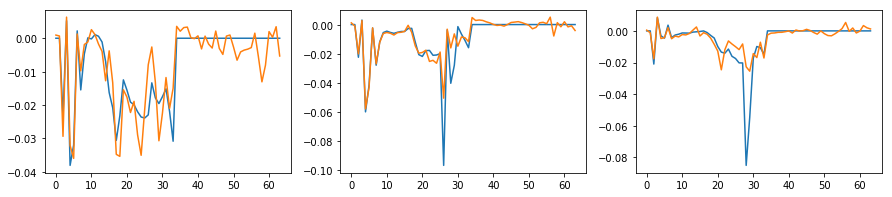

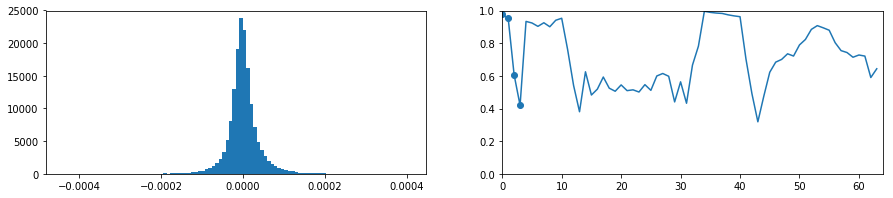

In [411]:
check_preds(enet)

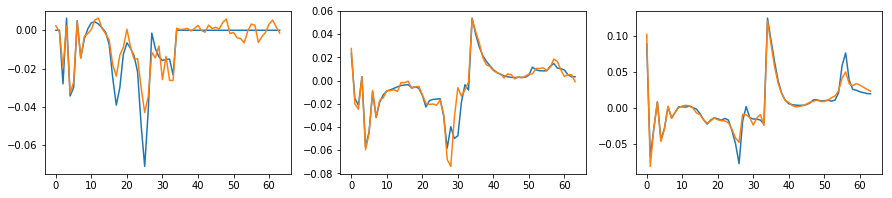

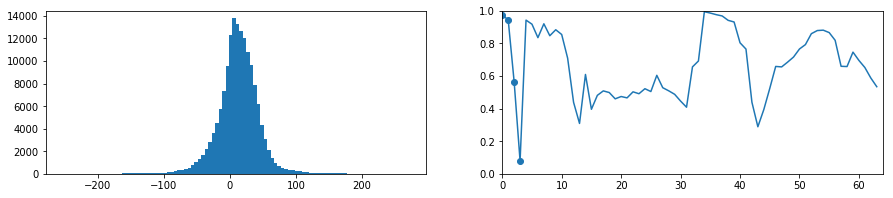

In [407]:
check_preds(net)